In [30]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os
import time
from sklearn.metrics import mean_squared_error
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt

# Suppress a specific warning
warnings.filterwarnings("ignore", category=UserWarning)

In [17]:
df = pd.read_csv("../Datasets/df_under_14.csv")
df = df.drop(['Unnamed: 0'],axis=1)
df['days_remaining'] = df['hospital_length_of_stay']-df['day']
df = df.drop(['hospital_length_of_stay','day'],axis=1)

# List of binary columns
columns_binary = [
    'intubated', 'cardiac_arrest', 'arrested_time', 'major_cardiac_events', 
    'clinically_diagnosed_infections', 'mechanical_ventilation', 'antiarrhythmic_therapies', 
    'renal_replacement_therapy_dialysis', 'cardiovascular_mechanical_support', 'echocardiogram', 
    'chest_x_ray', 'chest_ct', 'head_ct', 'antimicrobial', 'anticoagulation', 'steroid',
    'Bilateral Consolidation', 'Bilateral Ground Glass', 'Cardiomegaly', 'Edema', 'Effusion', 
    'Pneumothorax', 'Unilateral Consolidation', 'Unilateral Ground Glass', 'Bilateral Ground Glass Opacities',
    'Bilateral consolidationinfiltration', 'Subarachnoid Hemorrhage', 'Subdural Hemorrhage',
    'Emphysematous or Bronchiectasis changes', 'Emphysematous or Bronchiectatic changes', 
    'Pulmonary Embolism', 'Scarring or Fibrosis', 'Unilateral Ground Glass Opacities', 
    'Unilateral consolidationinfiltration'
]

# Define columns to exclude from scaling
columns_to_exclude = ['parent_id', 'days_remaining'] + columns_binary

# Select the columns to scale
columns_to_scale = [col for col in df.columns if col not in columns_to_exclude]

df = df[df['days_remaining']>0]

df

,parent_id,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,highest_mean_arterial_pressure,lowest_mean_arterial_pressure,highest_heart_rate,...,Bilateral Ground Glass,Cardiomegaly,Edema,Effusion,Unilateral Consolidation,Bilateral Ground Glass Opacities,Bilateral consolidationinfiltration,Pulmonary Embolism,Scarring or Fibrosis,days_remaining
0,2,122.0,80.0,72.0,24.0,92.0,36.3,0.000000,0.000000,92.0,...,1,0,0,0,0,0,0,0,0,4
1,2,114.0,72.0,60.0,18.0,92.0,35.9,0.000000,0.000000,67.0,...,0,0,0,0,0,0,0,0,0,3
2,2,117.0,73.0,62.0,16.0,95.0,36.0,0.000000,0.000000,65.0,...,0,0,0,0,0,0,0,0,0,2
3,2,125.0,76.0,76.0,18.0,97.0,36.3,0.000000,0.000000,76.0,...,0,0,0,0,0,0,0,0,0,1
8,3,112.0,69.0,66.0,18.0,96.0,36.5,0.000000,0.000000,71.0,...,0,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2549,521,138.0,95.0,92.0,20.0,94.0,37.1,98.666667,98.666667,92.0,...,0,0,0,0,0,0,0,0,0,1
2552,522,126.0,68.0,74.0,18.0,94.0,36.7,0.000000,0.000000,74.0,...,0,0,0,0,0,0,0,0,0,4
2553,522,119.0,68.0,77.0,20.0,97.0,36.6,0.000000,0.000000,82.0,...,0,0,0,0,0,0,0,0,0,3
2554,522,108.0,67.0,71.0,20.0,95.0,36.1,0.000000,0.000000,82.0,...,0,0,0,0,0,0,0,0,0,2


### Constant functions

In [18]:
# Define the SimpleRNN class for many-to-many prediction
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # RNN outputs all timesteps, not just the last one
        out, _ = self.rnn(x)  # RNN returns output for all timesteps
        out = self.fc(out)  # Pass through the fully connected layer for each timestep
        return out

# Define the data extraction function (many-to-many)
def get_data_for_parent(df, parent_id):
    data = df[df['parent_id'] == parent_id]
    features = data.drop(columns=['parent_id', 'days_remaining'])
    target = data['days_remaining'].values
    
    # Convert to tensors
    features_tensor = torch.tensor(features.values).float().unsqueeze(0)  # Add batch dimension
    target_tensor = torch.tensor(target).float().unsqueeze(0)  # Add batch dimension
    return features_tensor, target_tensor

# Define the ensemble prediction function
def ensemble_prediction(models, input_data):
    predictions = []
    
    # Get predictions from each model
    for model in models:
        model.eval()  # Switch to evaluation mode
        with torch.no_grad():
            output = model(input_data)
            predictions.append(output.squeeze().tolist())  # Store the predictions for each timestep
        
    # Average the predictions to form the final prediction at each timestep
    return torch.mean(torch.tensor(predictions), dim=0)

### Using minmax scaler to scale the data and doing a train test split as well

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform only the columns that need scaling
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Step 2: Split based on unique parent_id
unique_parent_ids = df['parent_id'].unique()

# Randomly shuffle and split into 75% train and 25% test
train_parent_ids, test_parent_ids = train_test_split(unique_parent_ids, test_size=0.25, random_state=42)

# Filter the dataset based on the split
train_df = df[df['parent_id'].isin(train_parent_ids)]
test_df = df[df['parent_id'].isin(test_parent_ids)]

# Display the results
print(f"Total rows in the dataset: {len(df)}")
print(f"Train dataset rows: {len(train_df)}")
print(f"Test dataset rows: {len(test_df)}")

# Example: Pass 75% (train_df) to the next function
for parent_id in train_df['parent_id'].unique():
    features, target = get_data_for_parent(train_df, parent_id)
    # Example: Print the features and target shapes
    print(f"Parent ID: {parent_id}, Features Shape: {features.shape}, Target Shape: {target.shape}")


Total rows in the dataset: 1536
Train dataset rows: 1161
Test dataset rows: 375
Parent ID: 2, Features Shape: torch.Size([1, 4, 65]), Target Shape: torch.Size([1, 4])
Parent ID: 3, Features Shape: torch.Size([1, 6, 65]), Target Shape: torch.Size([1, 6])
Parent ID: 7, Features Shape: torch.Size([1, 3, 65]), Target Shape: torch.Size([1, 3])
Parent ID: 11, Features Shape: torch.Size([1, 3, 65]), Target Shape: torch.Size([1, 3])
Parent ID: 19, Features Shape: torch.Size([1, 7, 65]), Target Shape: torch.Size([1, 7])
Parent ID: 21, Features Shape: torch.Size([1, 1, 65]), Target Shape: torch.Size([1, 1])
Parent ID: 22, Features Shape: torch.Size([1, 3, 65]), Target Shape: torch.Size([1, 3])
Parent ID: 23, Features Shape: torch.Size([1, 7, 65]), Target Shape: torch.Size([1, 7])
Parent ID: 24, Features Shape: torch.Size([1, 7, 65]), Target Shape: torch.Size([1, 7])
Parent ID: 26, Features Shape: torch.Size([1, 5, 65]), Target Shape: torch.Size([1, 5])
Parent ID: 27, Features Shape: torch.Size([

### Hyper parameter tuning

In [20]:
# Hyperparameter tuning configuration
tuning_params = {
    'hidden_size': [32, 64],
    'learning_rate': [0.001, 0.005],
    'num_epochs': [500, 1000]
}
best_mse = float('inf')
best_params = None
models = []

# Training loop with hyperparameter tuning
input_size = train_df.drop(columns=['parent_id', 'days_remaining']).shape[1]
output_size = 1  # Single output for each timestep
criterion = nn.MSELoss()

output_dir = "Models"
os.makedirs(output_dir, exist_ok=True)
start_time = time.time()

for hidden_size in tuning_params['hidden_size']:
    for learning_rate in tuning_params['learning_rate']:
        for num_epochs in tuning_params['num_epochs']:
            print(f"Training with hidden_size={hidden_size}, learning_rate={learning_rate}, num_epochs={num_epochs}...")
            fold_models = []
            mse_list = []
            
            for parent_id in train_df['parent_id'].unique():
                # Data for current parent_id
                features, target = get_data_for_parent(train_df, parent_id)

                # Initialize model
                model = SimpleRNN(input_size, hidden_size, output_size)
                optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                # Training
                model.train()
                for epoch in range(num_epochs):
                    optimizer.zero_grad()
                    output = model(features)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                # Save model and record loss
                fold_models.append(model)
                model.eval()
                with torch.no_grad():
                    predictions = model(features)
                    mse = criterion(predictions, target).item()
                    mse_list.append(mse)

            # Compute mean MSE for this parameter configuration
            mean_mse = np.mean(mse_list)
            print(f"Mean MSE for configuration: {mean_mse}")

            # Save the best configuration
            if mean_mse < best_mse:
                best_mse = mean_mse
                best_params = {'hidden_size': hidden_size, 'learning_rate': learning_rate, 'num_epochs': num_epochs}
                models = fold_models

end_time = time.time()
print(f"Best Parameters: {best_params}")
print(f"Total training time: {end_time - start_time:.2f} seconds")

Training with hidden_size=32, learning_rate=0.001, num_epochs=500...
Mean MSE for configuration: 2.346552695619299
Training with hidden_size=32, learning_rate=0.001, num_epochs=1000...
Mean MSE for configuration: 2.338662325067723
Training with hidden_size=32, learning_rate=0.005, num_epochs=500...
Mean MSE for configuration: 2.335478829830251
Training with hidden_size=32, learning_rate=0.005, num_epochs=1000...
Mean MSE for configuration: 2.3350237202137074
Training with hidden_size=64, learning_rate=0.001, num_epochs=500...
Mean MSE for configuration: 2.345597788120838
Training with hidden_size=64, learning_rate=0.001, num_epochs=1000...
Mean MSE for configuration: 2.3367222872186213
Training with hidden_size=64, learning_rate=0.005, num_epochs=500...
Mean MSE for configuration: 2.334917900410104
Training with hidden_size=64, learning_rate=0.005, num_epochs=1000...
Mean MSE for configuration: 2.334773577527797
Best Parameters: {'hidden_size': 64, 'learning_rate': 0.005, 'num_epochs':

In [28]:
# Training function
def train_rnn(train_df, input_size, hidden_size, output_size, learning_rate, num_epochs):
    models = []
    criterion = nn.MSELoss()

    # Train a model for each unique parent_id
    for parent_id in train_df['parent_id'].unique():
        features, target = get_data_for_parent(train_df, parent_id)

        # Initialize model
        model = SimpleRNN(input_size, hidden_size, output_size)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Training
        model.train()
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        models.append(model)
    return models

# Evaluate the model on test data
def evaluate_rnn(models, test_df):
    X_test = test_df.drop(columns=['parent_id', 'days_remaining'])
    y_test = test_df['days_remaining']

    y_true, y_pred = [], []
    for i in range(len(X_test)):
        test_sample = torch.tensor(X_test.iloc[i].values).float().unsqueeze(0).unsqueeze(0)
        true_value = y_test.iloc[i]
        prediction = ensemble_prediction(models, test_sample)
        y_true.append(true_value)
        y_pred.append(prediction)

    mse = mean_squared_error(y_true, y_pred)
    return mse, y_true, y_pred

# Set hyperparameters
hidden_size = 64
learning_rate =0.005
num_epochs = 1000

# Prepare input size and output size
input_size = train_df.drop(columns=['parent_id', 'days_remaining']).shape[1]
output_size = 1

# Train the RNN with the best hyperparameters
print(f"Training with hidden_size={hidden_size}, learning_rate={learning_rate}, num_epochs={num_epochs}...")
start_time = time.time()
models = train_rnn(train_df, input_size, hidden_size, output_size, learning_rate, num_epochs)
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

# Evaluate on test data
mse, y_true, y_pred = evaluate_rnn(models, test_df)
print(f"Best Model MSE on test data: {mse}")

Training with hidden_size=64, learning_rate=0.005, num_epochs=1000...
Training completed in 130.72 seconds.
Best Model MSE on test data: 8.034424454111576


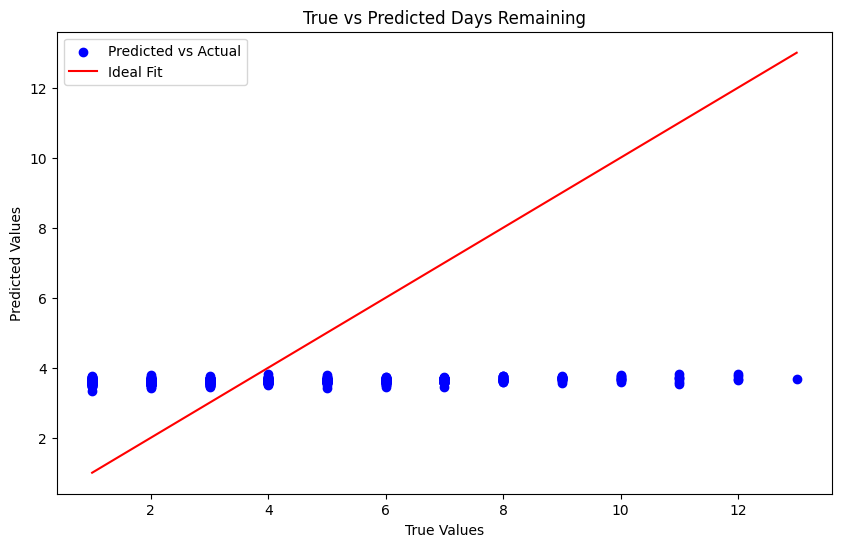

In [32]:
# Plotting true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', label='Ideal Fit')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Days Remaining')
plt.legend()
plt.show()

In [34]:
y_pred

[tensor(3.7201),
 tensor(3.6582),
 tensor(3.6794),
 tensor(3.6397),
 tensor(3.6580),
 tensor(3.6978),
 tensor(3.6713),
 tensor(3.4537),
 tensor(3.4366),
 tensor(3.4206),
 tensor(3.5568),
 tensor(3.5227),
 tensor(3.5222),
 tensor(3.5481),
 tensor(3.5391),
 tensor(3.4652),
 tensor(3.5675),
 tensor(3.4945),
 tensor(3.5264),
 tensor(3.5850),
 tensor(3.6849),
 tensor(3.6568),
 tensor(3.7252),
 tensor(3.7026),
 tensor(3.6834),
 tensor(3.6886),
 tensor(3.6119),
 tensor(3.6271),
 tensor(3.6402),
 tensor(3.6729),
 tensor(3.5541),
 tensor(3.7153),
 tensor(3.6813),
 tensor(3.6532),
 tensor(3.6660),
 tensor(3.6718),
 tensor(3.6576),
 tensor(3.7185),
 tensor(3.7177),
 tensor(3.7707),
 tensor(3.7520),
 tensor(3.6822),
 tensor(3.7229),
 tensor(3.6135),
 tensor(3.5190),
 tensor(3.5122),
 tensor(3.5094),
 tensor(3.5376),
 tensor(3.6710),
 tensor(3.7344),
 tensor(3.6681),
 tensor(3.6564),
 tensor(3.6378),
 tensor(3.6628),
 tensor(3.6022),
 tensor(3.3380),
 tensor(3.6284),
 tensor(3.5501),
 tensor(3.5398